In [1]:
import numpy as np
import torch 
import torch.nn as nn
import math 
import h5py
import yaml
import pickle
import sys
import os
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)


import src.models as models
import src.dataset as ds
import src.train_pcdae as train_pcdae
import src.inference_pcdae as inference
import src.data_preparation as data_prep

In [2]:
with h5py.File("scaling_noise_level_pcdae.h5", "r") as f:
    
    seed_vec_pcdae = f['results/seed'][:]
    sigma_vec_pcdae = f['results/sigma_max'][:]
    loss_init_pcdae = f['results/loss_init'][:]
    loss_refine1_pcdae = f['results/loss_refine1'][:]
    loss_refine2_pcdae = f['results/loss_refine2'][:]
    pickled_config = f['results/config'][()]

config_pcdae = pickle.loads(pickled_config)

In [3]:
unique_sigma = np.unique(sigma_vec_pcdae)
loss_refine1_dict = {ele: [] for ele in unique_sigma}
loss_refine2_dict = {ele: [] for ele in unique_sigma}

for i in range(len(seed_vec_pcdae)):
    
    loss_refine1_dict[sigma_vec_pcdae[i]].append(loss_refine1_pcdae[i])
    loss_refine2_dict[sigma_vec_pcdae[i]].append(loss_refine2_pcdae[i])


mean_refine1_plot = []
mean_refine2_plot = []
std_refine1_plot = []
std_refine2_plot = []

for i, (size, vec) in enumerate(loss_refine1_dict.items()):
    vec_sqrt = np.sqrt(vec)
    mean_refine1_plot.append(np.mean(vec_sqrt))
    std_refine1_plot.append(np.std(vec_sqrt))

for i, (size, vec) in enumerate(loss_refine2_dict.items()):
    vec_sqrt = np.sqrt(vec)
    mean_refine2_plot.append(np.mean(vec_sqrt))
    std_refine2_plot.append(np.std(vec_sqrt))


mean_refine1_plot = np.array(mean_refine1_plot)
mean_refine2_plot = np.array(mean_refine2_plot)
std_refine1_plot = np.array(std_refine1_plot)
std_refine2_plot = np.array(std_refine2_plot)


In [4]:
print(mean_refine1_plot)
print(std_refine1_plot)

print(mean_refine2_plot)
print(std_refine2_plot)

[0.07359374 0.06387713 0.03994783 0.03889048 0.03185713 0.02638627
 0.02472118 0.02463843]
[0.03756613 0.03316589 0.02362149 0.02130796 0.01835024 0.01590983
 0.01669591 0.01506652]
[0.07358113 0.06387972 0.0399456  0.03888699 0.03185772 0.02638622
 0.02472111 0.02463844]
[0.03753892 0.03316103 0.02361997 0.02130231 0.01835006 0.01590977
 0.01669594 0.01506656]


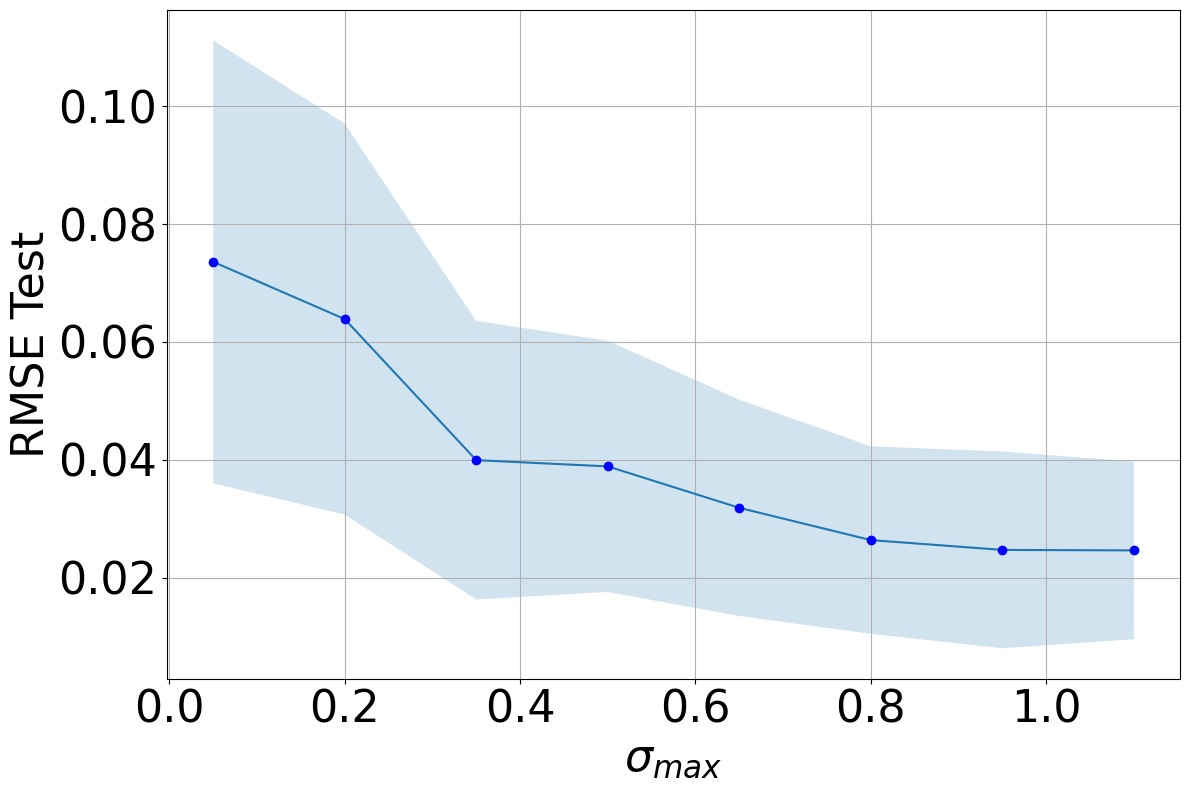

In [5]:

fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

plt.plot(unique_sigma, mean_refine1_plot)
plt.plot(unique_sigma, mean_refine1_plot, 'o', color="blue")
plt.fill_between(unique_sigma,
                    mean_refine1_plot - std_refine1_plot,
                    mean_refine1_plot + std_refine1_plot,
                    alpha=0.2)

plt.xlabel(r'$\sigma_{max}$', fontsize=32)
plt.ylabel(r'RMSE Test', fontsize=32)
# plt.ylabel(r'$T/\Lambda$', fontsize=32)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
# plt.legend(fontsize=25)
# plt.ylim(0.005, 0.09)
plt.tight_layout()
plt.grid()
# plt.savefig("PCDAE_sigma_max_scaling.png")

In [6]:

#### inference study

def get_model_dataset(seed, device, config):
    
    data_dict = data_prep.prepare_data_model(seed, "../" + config['data']["data_path"], config['training']["ratio_test_val_train"])

    X_test_scaled, y_test_scaled = data_dict['test']
    scaler_X, scaler_Y = data_dict['scalers']

    batch_size = X_test_scaled.shape[0]

    test_dataset = ds.LTPDataset(X_test_scaled, y_test_scaled)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    ###* define the PCDAE architecture
    x_dim = config['model']['x_dim']
    y_dim = config['model']['y_dim']
    hidden_dim = config['model']['hidden_dim']
        
    sigma_min = float(config['model']['sigma_min'])
    sigma_max = float(config['model']['sigma_max'])
        
    pcdae = models.PCDAE(x_dim=x_dim, y_dim=y_dim, hidden_dim=hidden_dim).to(device)
    pcdae.load_state_dict(torch.load(f"../models_saved/pcdae_inference_{seed}.pth"))
    
    return {
        'scalers': (scaler_X, scaler_Y),
        'data': (test_dataset, test_dataloader),
        'pcdae': pcdae,
        'sigmas': (sigma_min, sigma_max)
    }


In [7]:

config_file = "../config_pcdae.yaml"
seed_vec = np.arange(1, 400, 40, dtype=int)
device = torch.device('cpu')


try:
    with open(config_file, 'r') as file:
        config = yaml.safe_load(file)
except FileNotFoundError:
    print("Error: The file 'config.yaml' was not found.")
    exit()
except yaml.YAMLError as e:
    print(f"Error parsing YAML file: {e}")
    exit()
    


In [8]:

pcdae_vec = []
for seed in seed_vec:
    dict_aux = get_model_dataset(seed, device, config)
    pcdae_vec.append(dict_aux)

In [9]:

### test seed 1

alpha_dual = 1e-4
beta_dual = 1e-3

# ### different promising attempt
# alpha_dual = 1e-2
# beta_dual = 1e-1

def nb_level_study(nb_levels_vec, size_level=10):

    test_init_vec = []
    test_refine_vec = []
    test_dual_vec = []

    
    for counter, nb_levels in enumerate(nb_levels_vec):
        
        aux_init = []
        aux_refine = []
        aux_dual = []
        
        for idx in range(len(pcdae_vec)):
            
            torch.manual_seed(seed_vec[idx])
            np.random.seed(seed_vec[idx])
            
            test_dataset, test_dataloader = pcdae_vec[idx]['data']
            scaler_X, scaler_Y = pcdae_vec[idx]['scalers']
            pcdae = pcdae_vec[idx]['pcdae']
            sigma_min, sigma_max = pcdae_vec[idx]['sigmas']

            noise_schedule = np.geomspace(sigma_max, sigma_min, nb_levels)
            steps_vec = np.linspace(size_level, size_level, nb_levels, dtype=int)

            test_init_loss = 0.0
            test_refine_loss = 0.0
            test_dual_loss = 0.0

            for i, (x, y) in enumerate(test_dataloader):
                
                y_init = torch.randn_like(y)
                
                y_refined = inference.inference_PCDAE_base(pcdae, x, y_init, noise_schedule, \
                                    steps_vec=steps_vec, step_size=0.01, eps_conv=1e-4, eps_clip=5e-1)
                
                y_dual = inference.inference_PCDAE_dual(pcdae, x, y_init, noise_schedule, \
                                    steps_vec=steps_vec, scaler_X=scaler_X, scaler_Y=scaler_Y,\
                                    step_size=0.01, eps_conv=1e-4, eps_clip=5e-1, alpha_dual=alpha_dual, beta_dual=beta_dual)
                
                loss_init = nn.MSELoss()(y_init, y)
                loss_refined = nn.MSELoss()(y_refined, y)
                loss_dual = nn.MSELoss()(y_dual, y)
                
                test_init_loss += loss_init.item()
                test_refine_loss += loss_refined.item()
                test_dual_loss += loss_dual.item()
        
            test_init_loss /= len(test_dataloader)
            test_refine_loss /= len(test_dataloader)
            test_dual_loss /= len(test_dataloader)
            
            aux_init.append(test_init_loss)
            aux_refine.append(test_refine_loss)
            aux_dual.append(test_dual_loss)
        
        test_init_vec.append(aux_init)
        test_refine_vec.append(aux_refine)
        test_dual_vec.append(aux_dual)
        
        print("counter: ", (counter+1)/len(nb_levels_vec))
        
    return test_init_vec, test_refine_vec, test_dual_vec

In [10]:

nb_levels_vec = [50, 150, 300, 450, 600, 750, 900, 1050]
# nb_levels_vec = [50, 150, 300]
size_level = 10
test_init_vec, test_refine_vec, test_dual_vec = nb_level_study(nb_levels_vec, size_level=size_level)




counter:  0.125
counter:  0.25
counter:  0.375
counter:  0.5
counter:  0.625
counter:  0.75
counter:  0.875
counter:  1.0


In [11]:
test_refine_arr = np.array(test_refine_vec)

mean_refine_plot = np.mean(np.sqrt(test_refine_arr), axis=1)
std_refine_plot = np.std(np.sqrt(test_refine_arr), axis=1)


test_dual_arr = np.array(test_dual_vec)

mean_dual_plot = np.mean(np.sqrt(test_dual_arr), axis=1)
std_dual_plot = np.std(np.sqrt(test_dual_arr), axis=1)

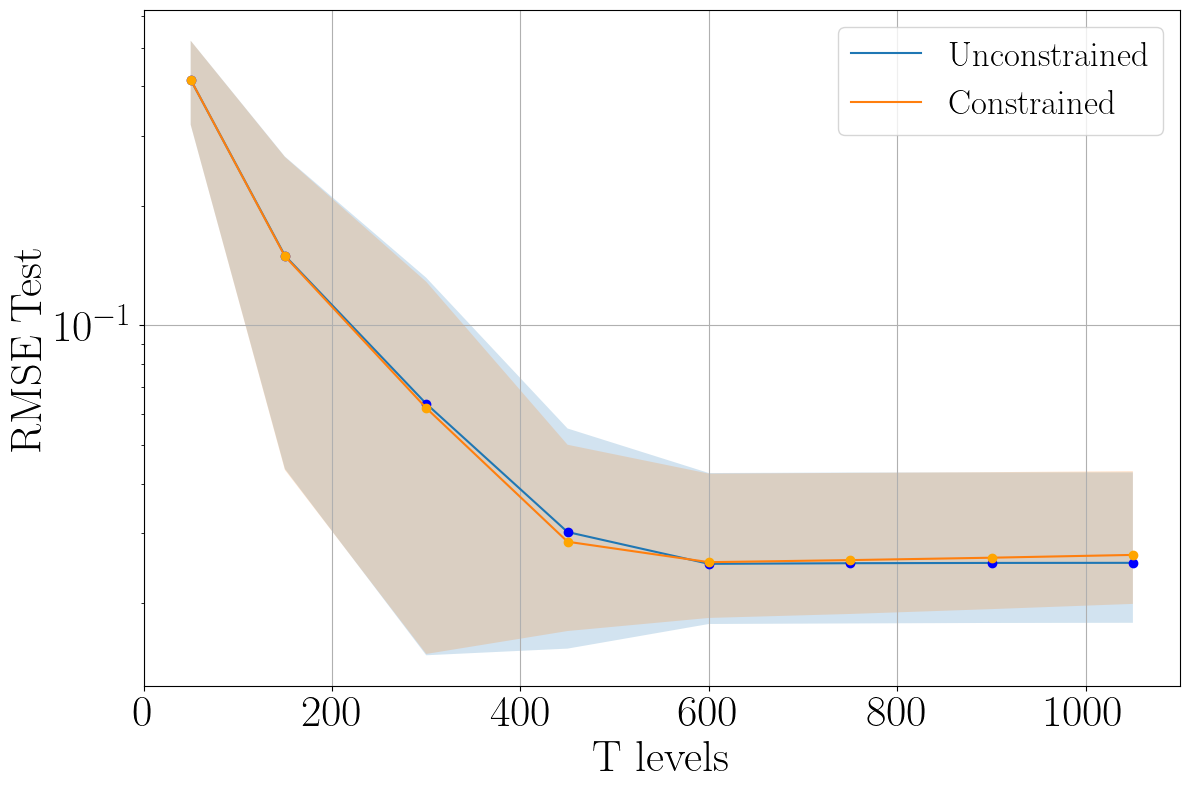

In [12]:


fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

plt.plot(nb_levels_vec, mean_refine_plot, label="Unconstrained")
plt.plot(nb_levels_vec, mean_refine_plot, 'o', color="blue")
plt.fill_between(nb_levels_vec,
                    np.abs(mean_refine_plot - std_refine_plot)+1e-2,
                    mean_refine_plot + std_refine_plot,
                    alpha=0.2)

plt.plot(nb_levels_vec, mean_dual_plot, label="Constrained")
plt.plot(nb_levels_vec, mean_dual_plot, 'o', color="orange")
plt.fill_between(nb_levels_vec,
                    np.abs(mean_dual_plot - std_dual_plot)+1e-2,
                    mean_dual_plot + std_dual_plot,
                    alpha=0.2)


plt.xlabel(r'T levels', fontsize=32)
plt.ylabel(r'RMSE Test', fontsize=32)
# plt.ylabel(r'$T/\Lambda$', fontsize=32)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
plt.legend(fontsize=25)
# plt.ylim(0.005, 0.09)
plt.yscale('log')
plt.tight_layout()
plt.grid()


# plt.savefig("scaling_inference_T_V2.png")

In [14]:

### study K per level 

def K_level_study(K_size_vec, nb_levels=15):

    test_init_vec = []
    test_refine_vec = []
    test_dual_vec = []

    
    for counter, K_size in enumerate(K_size_vec):
        
        aux_init = []
        aux_refine = []
        aux_dual = []
        
        for idx in range(len(pcdae_vec)):
            
            torch.manual_seed(seed_vec[idx])
            np.random.seed(seed_vec[idx])
            
            test_dataset, test_dataloader = pcdae_vec[idx]['data']
            scaler_X, scaler_Y = pcdae_vec[idx]['scalers']
            pcdae = pcdae_vec[idx]['pcdae']
            sigma_min, sigma_max = pcdae_vec[idx]['sigmas']

            noise_schedule = np.geomspace(sigma_max, sigma_min, nb_levels)
            steps_vec = np.linspace(K_size, K_size, nb_levels, dtype=int)

            test_init_loss = 0.0
            test_refine_loss = 0.0
            test_dual_loss = 0.0

            for i, (x, y) in enumerate(test_dataloader):
                
                y_init = torch.randn_like(y)
                
                y_refined = inference.inference_PCDAE_base(pcdae, x, y_init, noise_schedule, \
                                    steps_vec=steps_vec, step_size=0.01, eps_conv=1e-4, eps_clip=5e-1)
                
                y_dual = inference.inference_PCDAE_dual(pcdae, x, y_init, noise_schedule, \
                                    steps_vec=steps_vec, scaler_X=scaler_X, scaler_Y=scaler_Y,\
                                    step_size=0.01, eps_conv=1e-4, eps_clip=5e-1, alpha_dual=alpha_dual, beta_dual=beta_dual)
                
                loss_init = nn.MSELoss()(y_init, y)
                loss_refined = nn.MSELoss()(y_refined, y)
                loss_dual = nn.MSELoss()(y_dual, y)
                
                test_init_loss += loss_init.item()
                test_refine_loss += loss_refined.item()
                test_dual_loss += loss_dual.item()
        
            test_init_loss /= len(test_dataloader)
            test_refine_loss /= len(test_dataloader)
            test_dual_loss /= len(test_dataloader)
            
            aux_init.append(test_init_loss)
            aux_refine.append(test_refine_loss)
            aux_dual.append(test_dual_loss)
        
        test_init_vec.append(aux_init)
        test_refine_vec.append(aux_refine)
        test_dual_vec.append(aux_dual)
        
        print("counter: ", (counter+1)/len(nb_levels_vec))
        
    return test_init_vec, test_refine_vec, test_dual_vec


In [15]:

K_size_vec = [10, 30, 100, 170, 240, 310, 380, 450]

nb_levels = 15
test_init_vec_K, test_refine_vec_K, test_dual_vec_K = K_level_study(K_size_vec, nb_levels=nb_levels)



counter:  0.125
counter:  0.25
counter:  0.375
counter:  0.5
counter:  0.625
counter:  0.75
counter:  0.875
counter:  1.0


In [16]:
test_refine_arr_K = np.array(test_refine_vec_K)
mean_refine_plot_K = np.mean(np.sqrt(test_refine_arr_K), axis=1)
std_refine_plot_K = np.std(np.sqrt(test_refine_arr_K), axis=1)


test_dual_arr_K = np.array(test_dual_vec_K)
mean_dual_plot_K = np.mean(np.sqrt(test_dual_arr_K), axis=1)
std_dual_plot_K = np.std(np.sqrt(test_dual_arr_K), axis=1)



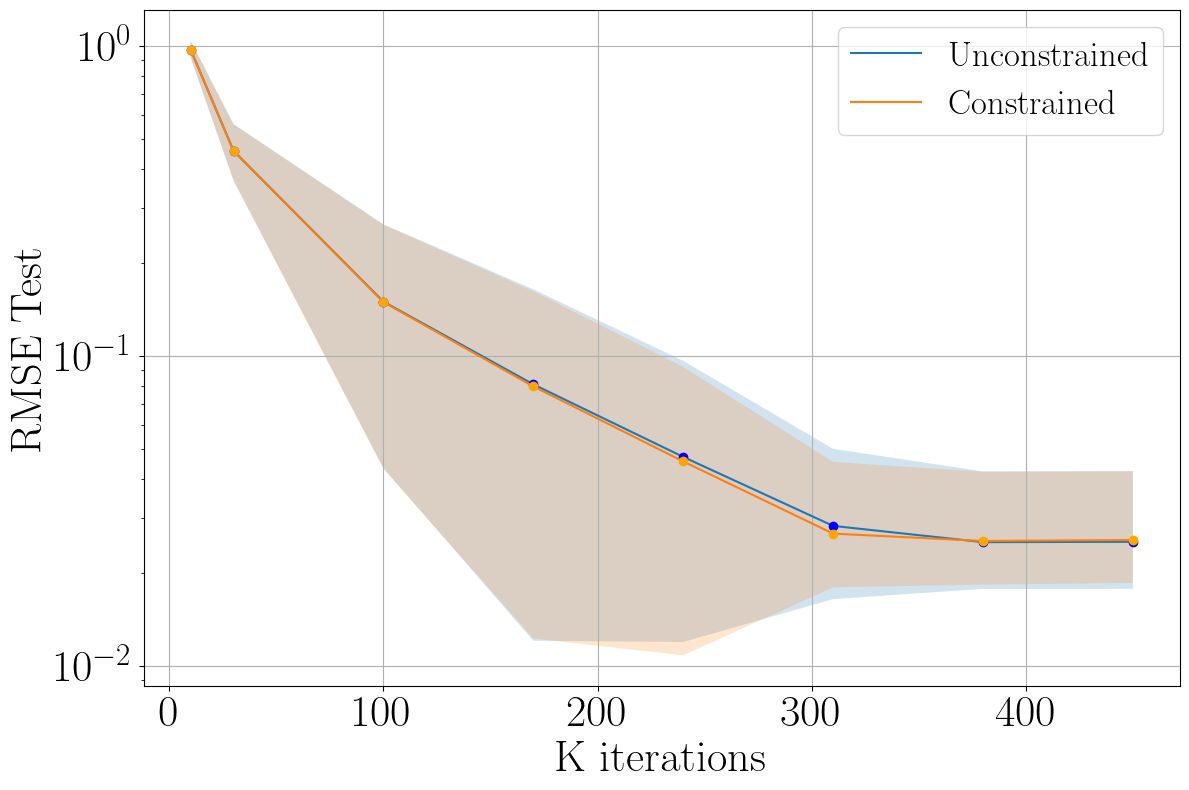

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

plt.plot(K_size_vec, mean_refine_plot_K, label="Unconstrained")
plt.plot(K_size_vec, mean_refine_plot_K, 'o', color="blue")
plt.fill_between(K_size_vec,
                    np.abs(mean_refine_plot_K - std_refine_plot_K)+1e-2,
                    mean_refine_plot_K + std_refine_plot_K,
                    alpha=0.2)

plt.plot(K_size_vec, mean_dual_plot_K, label="Constrained")
plt.plot(K_size_vec, mean_dual_plot_K, 'o', color="orange")
plt.fill_between(K_size_vec,
                    np.abs(mean_dual_plot_K - std_dual_plot_K)+1e-2,
                    mean_dual_plot_K + std_dual_plot_K,
                    alpha=0.2)


plt.xlabel(r'K iterations', fontsize=32)
plt.ylabel(r'RMSE Test', fontsize=32)
# plt.ylabel(r'$T/\Lambda$', fontsize=32)
plt.legend(fontsize=25)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
plt.legend(fontsize=25)
# plt.ylim(0.025, 0.04)
plt.yscale('log')
plt.tight_layout()
plt.grid()

# plt.savefig("scaling_inference_K_V2.png")

In [18]:
print(mean_dual_plot_K)
print(mean_refine_plot_K)

print((mean_dual_plot_K - mean_refine_plot_K)/mean_refine_plot_K*100)

[0.97408086 0.45920718 0.14935968 0.07983032 0.04573822 0.02675391
 0.02532346 0.02550969]
[0.97406188 0.45916847 0.14982643 0.08108402 0.04729756 0.02833432
 0.02511044 0.02517349]
[ 1.94862244e-03  8.43133494e-03 -3.11522012e-01 -1.54616907e+00
 -3.29687290e+00 -5.57770679e+00  8.48309229e-01  1.33553315e+00]


In [19]:
# print(test_init_loss)
# print(np.sqrt(test_refine_loss))
# print(np.sqrt(test_dual_loss))